In [1]:
import pandas as pd
import re

In [2]:
data_dir = '../data/'

#### How much are phytochemicals in drugs?

In [3]:
drug_ingredients = pd.read_csv(data_dir + 'drugbank/drug_id_name_map.csv', index_col=[0])
drug_ingredients.head()

,id,drug_name
1,DB00001,Lepirudin
2,DB00002,Cetuximab
3,DB00003,Dornase alfa
4,DB00004,Denileukin diftitox
5,DB00005,Etanercept


In [4]:
with open(data_dir + 'phytochemicals.txt', 'r') as f:
    lines = f.readlines()  

phytochemicals = [re.sub('\n', '', x) for x in lines]   
phytochemicals = [x.lower() for x in phytochemicals] 

print(phytochemicals[:10])
phytochemicals = set(phytochemicals)

['phytoene', 'zeaxanthin', 'lentinan', 'farnesyl pyrophosphate', 'pentose', 'carotene, gamma', 'theogallin', 'pectin', 'cembrene', 'pimaric acid']


In [5]:
drug_names = set(drug_ingredients.drug_name)

drugs_with_phytochemicals = dict()
phytochemicals_in_drugs = set()

phytochemicals = list(phytochemicals)

for drug_name in drug_names:
    ingredient = drug_name.lower()

    if ingredient in phytochemicals:
        drugs_with_phytochemicals[drug_name] = phytochemicals.index(ingredient)
        phytochemicals_in_drugs.add(ingredient)


print(phytochemicals_in_drugs)
print()
print('Number of drugs that contains phytochemicals:', len(drugs_with_phytochemicals), '/ out of', len(drug_names))

{'zeaxanthin', 'tocopherol', 'cholecalciferol', 'testosterone', 'rutin', 'tannic acid', 'pectin', 'geraniol', 'phenylalanine', 'phenol', 'curcumin', 'thymol', 'lycopene', 'beta carotene', 'tyrosine', 'betulinic acid', 'menthol', 'inulin', 'camphor', 'tryptophan', 'capsaicin', 'hesperidin', 'cholesterol', 'paclitaxel', 'salicylic acid', 'lutein'}

Number of drugs that contains phytochemicals: 26 / out of 4225


### Data Analysis
(in training dataset)

#### Drugs

In [6]:
drug_inchi_key = pd.read_csv(data_dir + 'triplets/drugs_inchi_key.tsv', sep='\t', index_col=[0])
print(drug_inchi_key.head(3))
print()


drug_subclass = pd.read_csv(data_dir + 'triplets/drug_subclass.tsv', sep='\t', index_col=[0])
print(drug_subclass.head(3))
print()

drug_salts = pd.read_csv(data_dir + 'triplets/drug_salts.tsv', sep='\t', index_col=[0])
print(drug_salts.head(3))
print()

drug_ingredients = pd.read_csv(data_dir + 'triplets/ingredients.tsv', sep='\t', index_col=[0])
print(drug_ingredients.head(3))
print()

drug_interactions = pd.read_csv(data_dir + 'triplets/ddi.tsv', sep='\t', index_col=[0])
print(drug_interactions.head(3))
print()

        id       relation                    inchi_key
1  DB00006  has_inchi_key  OIRCOABEOLEUMC-GEJPAHFPSA-N
2  DB00007  has_inchi_key  GFIJNRVAKGFPGQ-LIJARHBVSA-N
3  DB00014  has_inchi_key  BLCLNMBMMGCOAS-URPVMXJPSA-N

        id     relation subclass
1  DB00001  in_subclass  class_0
2  DB00002  in_subclass  class_0
3  DB00003  in_subclass  class_0

      drug  relation       salt_id
1  DB00007  contains  DBSALT000105
2  DB00007  contains  DBSALT003182
3  DB00010  contains  DBSALT001439

   drug_name  relation ingredient
0   refludan  contains    DB00001
1    erbitux  contains    DB00002
2  pulmozyme  contains    DB00003

     drug1                        interaction    drug2
0  DB06605  increase_anticoagulant_activities  DB00001
1  DB06695  increase_anticoagulant_activities  DB00001
2  DB01254                  increase_bleeding  DB00001



#### Food

In [15]:
food_compounds = pd.read_csv(data_dir + 'triplets/food_compound.tsv', sep='\t', index_col=[0])
print(food_compounds.head())
print()

compounds_cas_num = pd.read_csv(data_dir + 'triplets/compounds_cas_number.tsv', sep='\t', index_col=[0])
print(compounds_cas_num.head())
print()

     food_id  relation compound_id
0  FOOD00001  contains   FDB013255
1  FOOD00001  contains   FDB011904
2  FOOD00002  contains   FDB014613
3  FOOD00002  contains   FDB008322
4  FOOD00002  contains   FDB000474

  compound_id        relation cas_number
0   FDB009065  has_cas_number    79-92-5
1   FDB005805  has_cas_number   475-20-7
2   FDB003713  has_cas_number  7440-21-3
3   FDB008738  has_cas_number   108-46-3
4   FDB012485  has_cas_number    98-92-0



#### Drug Supplements

In [ ]:
ds_ingredients = pd.read_csv(data_dir + 'triplets/ds_ingredients.tsv', sep='\t', index_col=[0])
print(ds_ingredients.head())
print()

ds_relations = pd.read_csv(data_dir + 'triplets/ds_relations.tsv', sep='\t', index_col=[0])
print(ds_relations.head())
print()

## Graph visualization

In [3]:
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import nn
from torch import Tensor
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import WebKB
import torch_geometric.transforms as T
from torch_geometric.data import Data
import networkx as nx
from networkx.algorithms import community
from ogb.linkproppred import Evaluator, PygLinkPropPredDataset
import random
import itertools

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### BioKG

In [9]:
dataset_dir = '../data/dataset-ogb/'

dataset = PygLinkPropPredDataset(name='ogbl-ddi', root=dataset_dir, transform=T.ToSparseTensor())
data = dataset[0]

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')

Number of nodes: 4267
Number of edges: 2135822


In [10]:
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [7]:
split_edge = dataset.get_edge_split()
train_edge, valid_edge, test_edge = split_edge["train"], split_edge["valid"], split_edge["test"]
train_edge

{'edge': tensor([[4039, 2424],
         [4039,  225],
         [4039, 3901],
         ...,
         [ 647,  708],
         [ 708,  338],
         [ 835, 3554]])}

In [11]:
def random_sample(edge_index, num_nodes, k=10):
    nodes_idx = random.sample(range(num_nodes), k)
    mask = torch.from_numpy(np.isin(edge_index, nodes_idx).sum(axis=0) > 0)
    mask = mask.expand(2,-1)

    # select just edges with generated node index (nodes_idx)
    edge_index_sample = edge_index * mask 

    # get rid of 0s columns
    non_empty_mask = edge_index_sample.sum(dim=0).bool()
    edge_index_sample = edge_index_sample[:,non_empty_mask]
    
    return edge_index_sample

In [ ]:
random_sample(torch.transpose(train_edge['edge'], 0, 1), data.num_nodes)

In [125]:
num_nodes = edge_index_sample.unique()
# num_nodes.size(0)
data = Data(edge_index=edge_index_sample, num_nodes=num_nodes.size(0))
data

Data(edge_index=[2, 5058], num_nodes=1858)

In [88]:
edge_index = data.edge_index.numpy()
print(edge_index.shape)
index = 225
edge_example_outward = edge_index_sample[:, np.where(edge_index_sample[0]==index)[0]]
edge_example_inward = edge_index_sample[:, np.where(edge_index_sample[1] == index)[0]]
edge_example_outward

(2, 5058)


tensor([[ 225,  225,  225],
        [1850,  567, 3520]])

In [89]:
edge_example_inward.shape

torch.Size([2, 0])

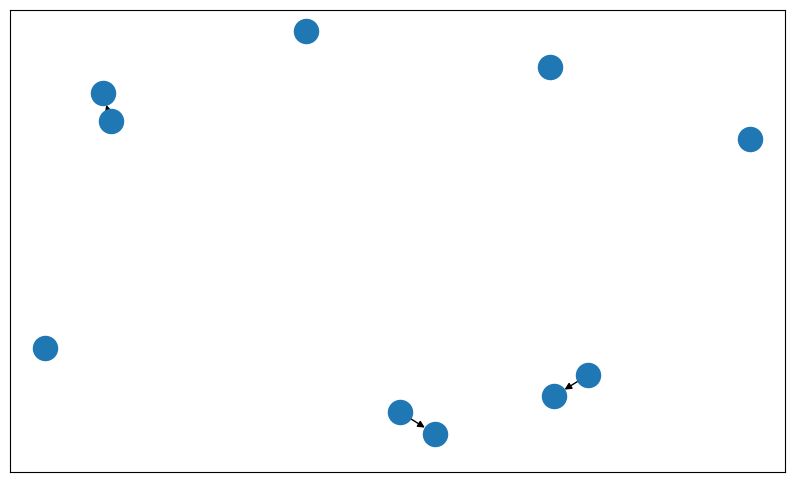

In [90]:
node_example = np.unique(np.concatenate(
    [edge_example_outward.flatten(), edge_example_inward.flatten()]))
plt.figure(figsize=(10, 6))
G = nx.DiGraph()
G.add_nodes_from(node_example)
G.add_edges_from(list(zip(edge_example_outward[0], edge_example_outward[1])))
G.add_edges_from(list(zip(edge_example_inward[0], edge_example_inward[1])))
nx.draw_networkx(G, with_labels=False)

In [13]:
def visuzlize_graph(data):
    G = to_networkx(data, to_undirected=False)
    pos = nx.spring_layout(G, seed=42)
    cent = nx.degree_centrality(G)
    node_size = list(map(lambda x: x * 800, cent.values()))
    cent_array = np.array(list(cent.values()))
    threshold = sorted(cent_array, reverse=True)[10]
    print("threshold", threshold)
    cent_bin = np.where(cent_array >= threshold, 1, 0.1)
    plt.figure(figsize=(12, 12))
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size,
                                   cmap=plt.cm.viridis,
                                   node_color=cent_bin,
                                   nodelist=list(cent.keys()),
                                   alpha=cent_bin)
    edges = nx.draw_networkx_edges(G, pos, width=0.25, alpha=0.6)
    plt.show()

### DrugBank data

In [5]:
my_data = 'triplets/train.tsv'
data_df = pd.read_csv(data_dir + my_data, sep='\t')
data_df = data_df.dropna()

In [6]:
nodes = data_df[['head', 'tail']].stack().unique()
print('Number of unique nodes:', len(nodes))
nodes_map = {node: i for i, node in enumerate(nodes)}

edges = data_df['relation'].unique()
edges_map = {edge: i for i, edge in enumerate(edges)}
print('Number of unique edges:', len(edges))

Number of unique nodes: 33079
Number of unique edges: 257


In [7]:
heads = data_df['head'].map(nodes_map)
tails = data_df['tail'].map(nodes_map)

In [8]:
edges = torch.tensor([heads.values, tails.values])

/tmp/ipykernel_15/1872461729.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  edges = torch.tensor([heads.values, tails.values])


tensor([[ 1462,   142,  2090,    58,  2105,  1297,   913,  1262,  1854,  1943,
          1830,  1057,   672,    31, 12704, 11042, 13190,  9767,  9767,  9767,
          9767,  9767,  9767,  9767,  9767,  9767,  9767,  9767,  9767,  9767,
          9767,  9767,  9767,  9767,  9767,  9767,  9767,  9767,  9767,  9767,
          9767,  9767,  9767,  9767,  9767,  9767,  9767,  9767,  9767,  9767,
          9767,  9767,  9767,  9767,  9767,  9767,  9767,  9767,  9767,  9767,
          9767,  9767,  9767,  9767,  9767,  9767,  9767],
        [ 9767,  9767, 11578, 11578, 11578, 11578, 11578, 11578, 11578, 11578,
         21214, 21214, 21214, 24326, 25922, 25922, 25922, 10690, 13764, 15176,
         25276, 14489, 12936, 31122, 26916, 27336, 31257, 14744, 25658, 26959,
         29214, 10800, 11477, 13955, 31455, 27305, 10849, 28030, 14013, 30640,
         26160, 12265, 30523, 13001, 31721, 30935, 29854, 27667, 26624, 12769,
         10430, 25107, 12651, 29492, 31886, 13477, 29366, 15649, 26241, 

/usr/local/lib/python3.8/dist-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


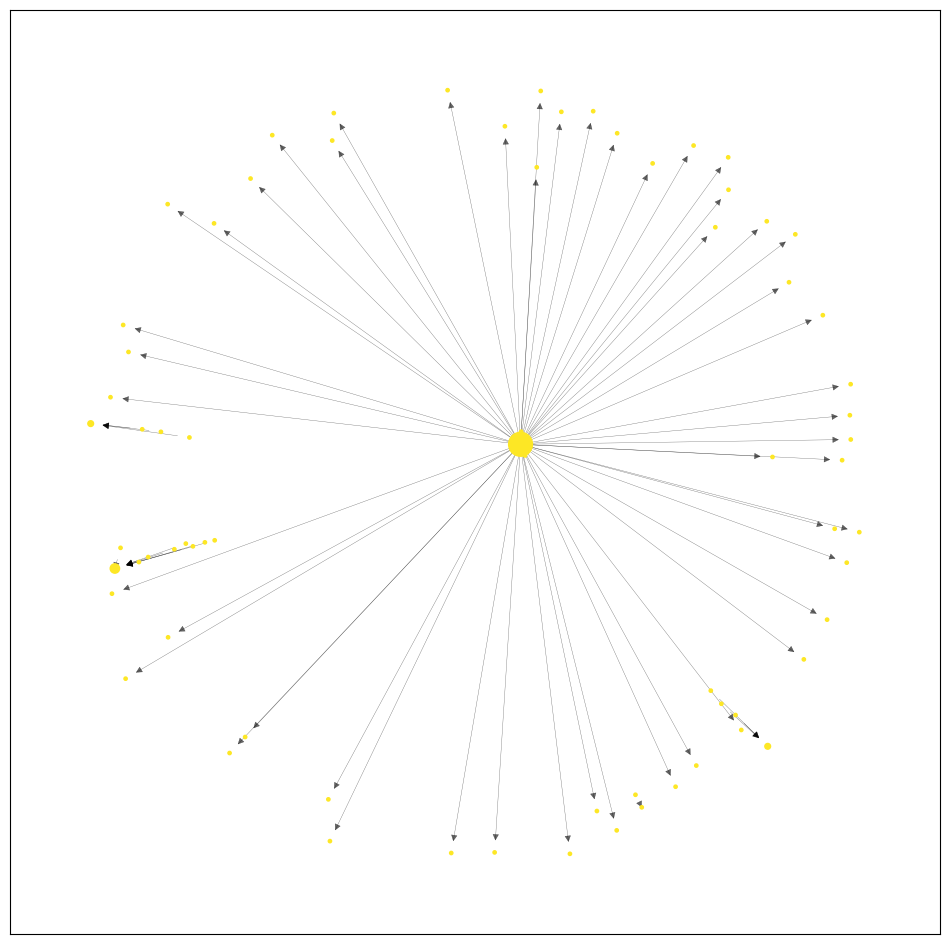

In [18]:
edges_sample = random_sample(edges, len(nodes), k=5)
print(edges_sample)
num_nodes = edges_sample.unique()
print('number of unique nodes:', num_nodes.size(0))
data_sample = Data(edge_index=edges_sample, num_nodes=num_nodes.size(0))

visuzlize_graph(data_sample)

## Analyze the training data (graph)

- node degree
- number of node types
- number of edges
- connections of enzymes/pathways to drugs

,count,mean,std,min,25%,50%,75%,max
0,33079.0,95.29,328.42,1.0,2.0,5.0,25.0,3891.0


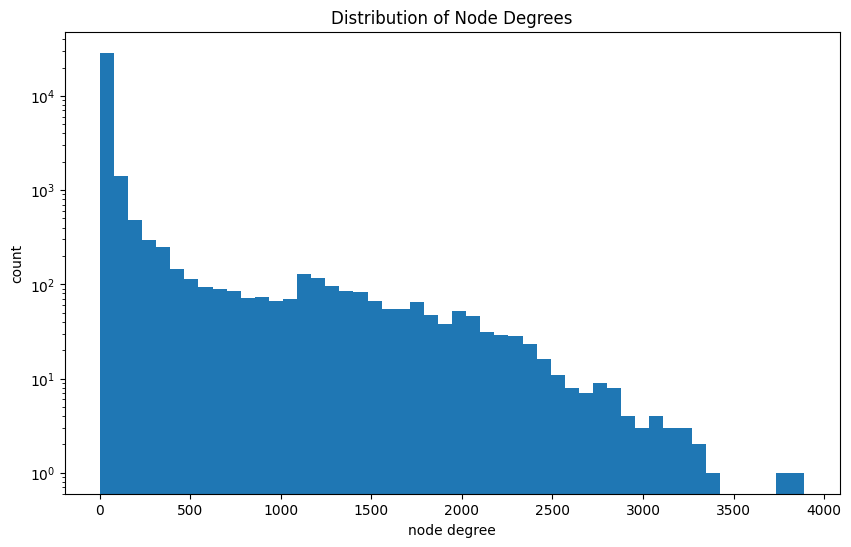

In [19]:
data = Data(edge_index=edges, num_nodes=len(nodes))

G = to_networkx(data, to_undirected=False)
degrees = [val for (node, val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
# print(len(degrees))
# print(sum(degrees))
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.xlabel("node degree")
plt.ylabel("count")
plt.yscale('log')
plt.title('Distribution of Node Degrees')
plt.show()

In [70]:
# node type distribution

# DB... - drug
# FOOD... - food
# FDB... - food compound
# cas number
# DBSALT... - drug salt
# subclass
# protein_...
# sideeffect_...
# disease_...
# SMP... - pathway
# pathway category 
# P/Q... - enzyme

# 12 types of nodes
nodes_list = data_df[['head', 'tail']].stack().unique()
nodes_df = pd.DataFrame({'node_id': nodes_list})

# it may be incorrect in some cases ??
nodes_df['node_type'] = list(itertools.repeat('cas_num', nodes_df.shape[0]))
nodes_df.loc[nodes_df['node_id'].str.contains("DB"), 'node_type'] = "drug"
nodes_df.loc[nodes_df['node_id'].str.contains("FOOD"), 'node_type'] = "food"
nodes_df.loc[nodes_df['node_id'].str.contains("FDB"), 'node_type'] = "food_compound"
nodes_df.loc[nodes_df['node_id'].str.contains("DBSALT"), 'node_type'] = "salt"
nodes_df.loc[nodes_df['node_id'].str.contains("class"), 'node_type'] = "drug_class"
nodes_df.loc[nodes_df['node_id'].str.contains("protein"), 'node_type'] = "protein"
nodes_df.loc[nodes_df['node_id'].str.contains("sideeffect"), 'node_type'] = "side_effect"
nodes_df.loc[nodes_df['node_id'].str.contains("disease"), 'node_type'] = "disease"
nodes_df.loc[nodes_df['node_id'].str.contains("SMP"), 'node_type'] = "pathway"
nodes_df.loc[nodes_df['node_id'].str.contains("pathway_cat"), 'node_type'] = "pathway_category"
nodes_df.loc[nodes_df['node_id'].str.contains("^[OPQ]\d+", regex=True), 'node_type'] = "enzyme"

nodes_df_grouped = nodes_df.groupby(by=['node_type']).count()
nodes_df_grouped.columns = ['count']
nodes_df_grouped = nodes_df_grouped.sort_values(by='count', ascending=False)
nodes_df_grouped

,count
node_type,
protein,13257
side_effect,8777
drug,2976
cas_num,2022
salt,1849
disease,1032
enzyme,1021
food,798
pathway,758


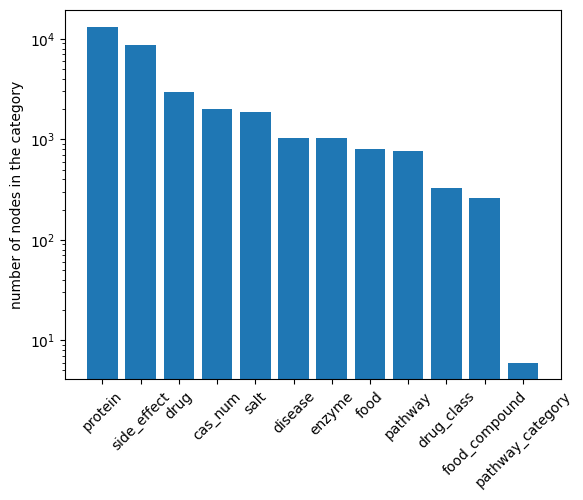

In [82]:
counts = nodes_df_grouped['count'].values
node_types = nodes_df_grouped.index

plt.bar(node_types, counts)
plt.xticks(rotation = 45) 
plt.yscale('log')
plt.ylabel('number of nodes in the category')
plt.show()

In [21]:
# edge type distribution
edge_types_grouped = data_df.groupby(by=['relation']).count()
edge_types_grouped = edge_types_grouped.drop(columns=['tail'])
edge_types_grouped.columns = ['count']
edge_types_grouped = edge_types_grouped.sort_values(by='count', ascending=False)
edge_types_grouped

,count
relation,
increase_serum_concentration,248592
decrease_excretion_rate,220665
decrease_metabolism,169663
protein-protein_reaction,145498
increase_adverse_effects,134405
...,...
increase_hypercoagulability,1
increase_dermatologic_adverse_activities,1
increase_skeletal_muscle_relaxing_activities,1


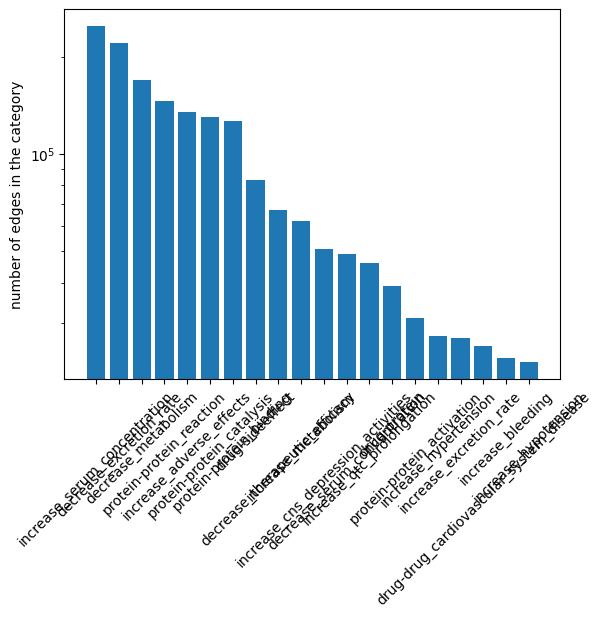

In [23]:
counts = list(edge_types_grouped['count'].values)[:20]
edge_types = list(edge_types_grouped.index)[:20]

plt.bar(edge_types, counts)
plt.xticks(rotation = 45) 
plt.yscale('log')
plt.ylabel('number of edges in the category')
plt.show()

In [ ]:
# connections of enzymes/pathways to drugs

In [ ]:
# vizualiztion for a specific drug(s)